# Combined BraTS 2020 Google Colab Notebook

## 1. Data Preparation (232_brats2020_get_data_ready.py)

In [4]:
!pip install segmentation-models-3D

In [62]:
import numpy as np
import nibabel as nib
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt
import os
import shutil
import segmentation_models_3D as sm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, Dropout
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.layers import Cropping3D, ZeroPadding3D
import tensorflow as tf
set_global_policy('mixed_float16')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Define the path to the dataset in Google Drive
base_path = '/content/drive/My Drive/BraTS2021/'
training_dataset_path = (base_path + 'BraTS2021_Training_Data/')
training_example = (training_dataset_path + '/BraTS2021_01135')
images_f1 = os.path.join(base_path, 'Training_Pot/input_data_3channels/images')
masks_f1 = os.path.join(base_path, 'Training_Pot/input_data_3channels/masks')

In [8]:
scaler = MinMaxScaler()

In [9]:
test_image_flair=nib.load(training_example + '/BraTS2021_01135_flair.nii.gz').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1=nib.load(training_example + '/BraTS2021_01135_t1.nii.gz').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(training_example + '/BraTS2021_01135_t1ce.nii.gz').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(training_example + '/BraTS2021_01135_t2.nii.gz').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(training_example + '/BraTS2021_01135_seg.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

1087.0


In [10]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


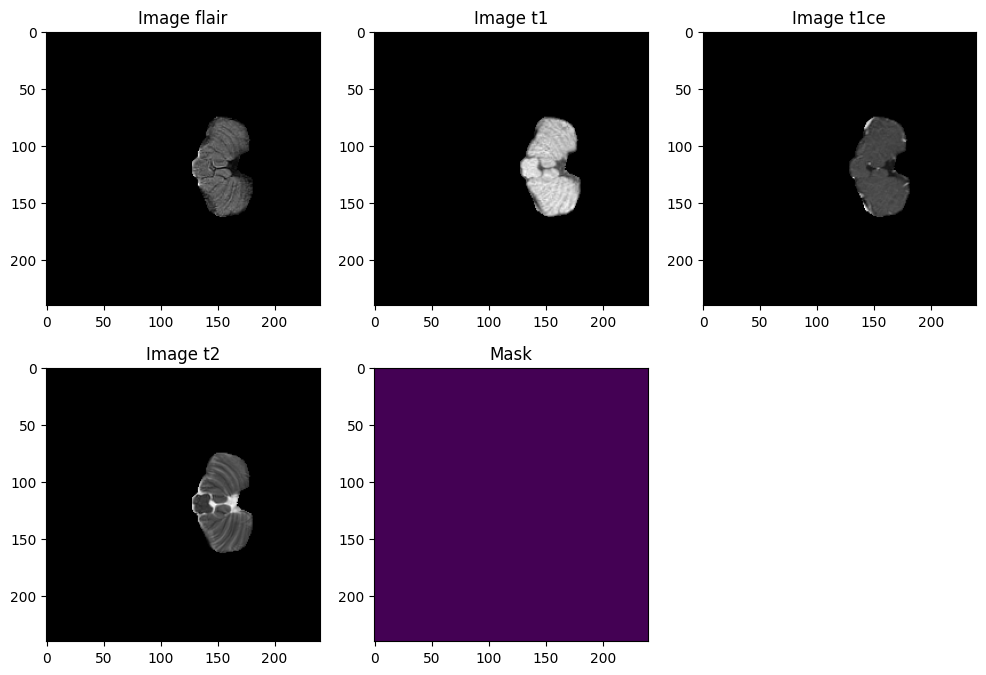

In [11]:
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [12]:
#Combining all 4 images to 4 channels of a numpy array.
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

-----------------------------------------------

In [13]:
# Apply cropping
combined_x=combined_x[24:216, 24:216, 16:208]
test_mask = test_mask[24:216, 24:216, 16:208]

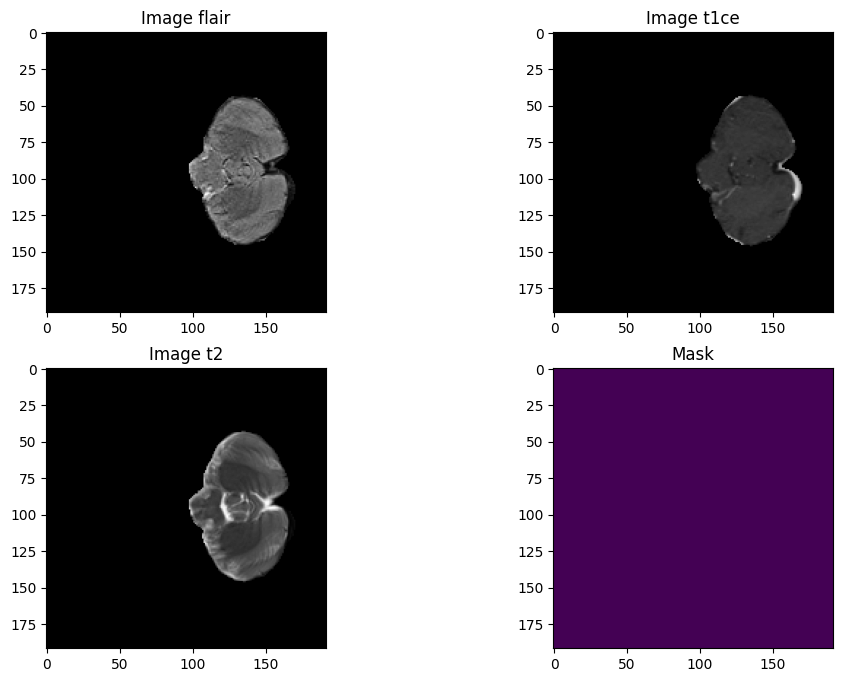

In [14]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

--------------------

#Helper Functions

In [15]:
# Helper Functions
def preprocess_mask(mask):
    """Reassign mask values, convert to uint8, and reassign label 4 to 3."""
    mask = mask.astype(np.uint8)
    mask[mask == 4] = 3
    return mask

In [16]:
def scale_image(image):
    """Apply MinMaxScaler to scale the image data."""
    return scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)

In [17]:
def crop_volume(volume, x_start=24, x_end=216, y_start=24, y_end=216, z_start=14, z_end=142):
    """Crop the volume to the desired dimensions."""
    return volume[x_start:x_end, y_start:y_end, z_start:z_end]

In [18]:
def one_hot_encode_mask(mask, num_classes=4):
    """Convert mask to one-hot encoding and cast to float32."""
    return to_categorical(mask, num_classes=num_classes).astype('float32')

In [19]:
def save_useful_data(base_path, img, combined_images, mask, counts, threshold=0.01):
    """Save the images and masks if the volume is sufficiently useful."""
    if (1 - (counts[0] / counts.sum())) > threshold:  # At least 1% useful volume
        print(f"Saving data for image {img}")
        np.save(base_path + f'Training_Pot/input_data_3channels/images/image_{img}.npy', combined_images)
        np.save(base_path + f'Training_Pot/input_data_3channels/masks/mask_{img}.npy', mask)
    else:
        print(f"Image {img} is not useful and will be skipped.")

In [20]:
def load_img(img_dir, img_list):
    """Loads and returns images as a numpy array from the given directory."""
    images = []
    for image_name in img_list:
        if image_name.split('.')[1] == 'npy':
            image = np.load(os.path.join(img_dir, image_name))
            images.append(image)
    return np.array(images)

In [21]:
# File Lists
t2_list = sorted(glob.glob(training_dataset_path + '/*/*t2.nii.gz'))
t1ce_list = sorted(glob.glob(training_dataset_path + '/*/*t1ce.nii.gz'))
flair_list = sorted(glob.glob(training_dataset_path + '/*/*flair.nii.gz'))
mask_list = sorted(glob.glob(training_dataset_path + '/*/*seg.nii.gz'))

In [22]:
# Example: Inspecting the first file in t2_list
first_t2_file = t2_list[0]  # Get the first file from the list
print(f"Inspecting file: {first_t2_file}")
t2_volume = nib.load(first_t2_file).get_fdata()
# Inspect the shape of the volume
print(f"Shape of the first T2 file: {t2_volume.shape}")

Inspecting file: /content/drive/My Drive/BraTS2021/BraTS2021_Training_Data/BraTS2021_00000/BraTS2021_00000_t2.nii.gz
Shape of the first T2 file: (240, 240, 155)


**RUN ONLY ONCE**

In [23]:
# Main Loop
for img in range(len(t2_list)):
    print(f"Now preparing image and masks number: {img}")

    # Load and preprocess each modality
    temp_image_t2 = scale_image(nib.load(t2_list[img]).get_fdata())
    temp_image_t1ce = scale_image(nib.load(t1ce_list[img]).get_fdata())
    temp_image_flair = scale_image(nib.load(flair_list[img]).get_fdata())
    print(f"[DEBUG] Image shapes: T2={temp_image_t2.shape}, T1CE={temp_image_t1ce.shape}, FLAIR={temp_image_flair.shape}")

    # Load and preprocess the mask
    temp_mask = preprocess_mask(nib.load(mask_list[img]).get_fdata())
    print(f"[DEBUG] Mask unique values before encoding: {np.unique(temp_mask)}")

    # Combine modalities into a single multichannel image
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    # Crop the images and masks
    temp_combined_images = crop_volume(temp_combined_images)
    temp_mask = crop_volume(temp_mask)
    print(f"[DEBUG] Cropped image shape: {temp_combined_images.shape}, Mask shape: {temp_mask.shape}")

    # Check mask label distribution
    val, counts = np.unique(temp_mask, return_counts=True)
    print(f"[DEBUG] Mask label counts: {dict(zip(val, counts))}")

    # One-hot encode the mask
    temp_mask = one_hot_encode_mask(temp_mask)
    print(f"[DEBUG] Mask shape after one-hot encoding: {temp_mask.shape}")

    # Save data
    if temp_combined_images.shape == (192, 192, 128, 3) and temp_mask.shape == (192, 192, 128, 4):
        np.save(os.path.join(images_f1, f"image_{img}.npy"), temp_combined_images)
        np.save(os.path.join(masks_f1, f"mask_{img}.npy"), temp_mask)
    else:
        print(f"[WARNING] Skipping image {img} due to mismatched shape.")

Streaming output truncated to the last 5000 lines.
[DEBUG] Mask shape after one-hot encoding: (192, 192, 128, 4)
Now preparing image and masks number: 417
[DEBUG] Image shapes: T2=(240, 240, 155), T1CE=(240, 240, 155), FLAIR=(240, 240, 155)
[DEBUG] Mask unique values before encoding: [0 1 2 3]
[DEBUG] Cropped image shape: (192, 192, 128, 3), Mask shape: (192, 192, 128)
[DEBUG] Mask label counts: {0: 4610657, 1: 3174, 2: 92292, 3: 12469}
[DEBUG] Mask shape after one-hot encoding: (192, 192, 128, 4)
Now preparing image and masks number: 418
[DEBUG] Image shapes: T2=(240, 240, 155), T1CE=(240, 240, 155), FLAIR=(240, 240, 155)
[DEBUG] Mask unique values before encoding: [0 1 2 3]
[DEBUG] Cropped image shape: (192, 192, 128, 3), Mask shape: (192, 192, 128)
[DEBUG] Mask label counts: {0: 4571209, 1: 25485, 2: 83375, 3: 38523}
[DEBUG] Mask shape after one-hot encoding: (192, 192, 128, 4)
Now preparing image and masks number: 419
[DEBUG] Image shapes: T2=(240, 240, 155), T1CE=(240, 240, 155), 

IndexError: list index out of range

In [24]:
# Example: Inspecting the first file in t2_list
first_t2_file = t2_list[1]  # Get the first file from the list
print(f"Inspecting file: {first_t2_file}")

# Load the file using nibabel
t2_volume = nib.load(first_t2_file).get_fdata()

# Inspect the shape of the volume
print(f"Shape of the first T2 file: {t2_volume.shape}")

Inspecting file: /content/drive/My Drive/BraTS2021/BraTS2021_Training_Data/BraTS2021_00002/BraTS2021_00002_t2.nii.gz
Shape of the first T2 file: (240, 240, 155)


**Step 2 Splitting Input Data**

In [25]:
# Step 2: Splitting Input Data
# Paths
input_folder = base_path + 'Training_Pot/input_data_3channels/'
output_folder = base_path + 'Training_Pot/input_data_128/'

In [26]:
# Input subfolders
images_folder = os.path.join(input_folder, 'images')
masks_folder = os.path.join(input_folder, 'masks')

In [27]:
# Output subfolders
train_images_folder = os.path.join(output_folder, 'train', 'images')
train_masks_folder = os.path.join(output_folder, 'train', 'masks')
val_images_folder = os.path.join(output_folder, 'validation', 'images')
val_masks_folder = os.path.join(output_folder, 'validation', 'masks')

In [28]:
# Ensure output folder structure exists
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_masks_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_masks_folder, exist_ok=True)

In [29]:
# Get list of all files in the images folder
image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]

In [30]:
# Shuffle files for randomness
random.seed(37)
random.shuffle(image_files)

In [31]:
# Split files into training and validation sets
split_index = int(0.75 * len(image_files))  # 75% for training, 25% for validation
train_files = image_files[:split_index]
val_files = image_files[split_index:]

In [32]:
# Function to copy individual files
def copy_file(source_path, dest_path):
    try:
        shutil.copyfile(source_path, dest_path)
    except Exception as e:
        print(f"Error copying file {source_path} to {dest_path}: {e}")

In [33]:
# Ensure destination folder structure exists
def ensure_directory_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"[INFO] Created directory: {folder_path}")


In [34]:
# Ensure all required directories exist
ensure_directory_exists(train_images_folder)
ensure_directory_exists(train_masks_folder)
ensure_directory_exists(val_images_folder)
ensure_directory_exists(val_masks_folder)

 - Easily run out of system ram without batch sizing due to file size.

In [39]:
# Function to process files in small batches
def copy_train_val_files(files, source_images_folder, dest_images_folder, source_masks_folder, dest_masks_folder, batch_size=20):
    """
    Copy files in smaller batches to reduce memory usage.
    """
    for i in range(0, len(files), batch_size):
        batch_files = files[i:i + batch_size]
        print(f"[INFO] Processing batch {i // batch_size + 1} with {len(batch_files)} files.")
        for file in batch_files:
            # Copy image
            source_image_path = os.path.join(source_images_folder, file)
            dest_image_path = os.path.join(dest_images_folder, file)
            try:
                shutil.copyfile(source_image_path, dest_image_path)
            except Exception as e:
                print(f"Error copying image {source_image_path} to {dest_image_path}: {e}")

            # Copy corresponding mask
            mask_file = file.replace('image_', 'mask_')
            source_mask_path = os.path.join(source_masks_folder, mask_file)
            dest_mask_path = os.path.join(dest_masks_folder, mask_file)
            try:
                shutil.copyfile(source_mask_path, dest_mask_path)
            except Exception as e:
                print(f"Error copying mask {source_mask_path} to {dest_mask_path}: {e}")

In [40]:
# Copy training files
print("[INFO] Copying training files...")
copy_train_val_files(train_files, images_folder, train_images_folder, masks_folder, train_masks_folder)

[INFO] Copying training files...
[INFO] Processing batch 1 with 20 files.
[INFO] Processing batch 2 with 20 files.
[INFO] Processing batch 3 with 20 files.
[INFO] Processing batch 4 with 20 files.
[INFO] Processing batch 5 with 20 files.
[INFO] Processing batch 6 with 20 files.
[INFO] Processing batch 7 with 20 files.
[INFO] Processing batch 8 with 20 files.
[INFO] Processing batch 9 with 20 files.
[INFO] Processing batch 10 with 20 files.
[INFO] Processing batch 11 with 20 files.
[INFO] Processing batch 12 with 20 files.
[INFO] Processing batch 13 with 20 files.
[INFO] Processing batch 14 with 20 files.
[INFO] Processing batch 15 with 20 files.
[INFO] Processing batch 16 with 20 files.
[INFO] Processing batch 17 with 20 files.
[INFO] Processing batch 18 with 20 files.
[INFO] Processing batch 19 with 20 files.
[INFO] Processing batch 20 with 20 files.
[INFO] Processing batch 21 with 20 files.
[INFO] Processing batch 22 with 20 files.
[INFO] Processing batch 23 with 20 files.
[INFO] Pro

In [41]:
# Copy validation files
print("[INFO] Copying validation files...")
copy_train_val_files(val_files, images_folder, val_images_folder, masks_folder, val_masks_folder)

[INFO] Copying validation files...
[INFO] Processing batch 1 with 20 files.
[INFO] Processing batch 2 with 20 files.
[INFO] Processing batch 3 with 20 files.
[INFO] Processing batch 4 with 20 files.
[INFO] Processing batch 5 with 20 files.
[INFO] Processing batch 6 with 20 files.
[INFO] Processing batch 7 with 20 files.
[INFO] Processing batch 8 with 20 files.
[INFO] Processing batch 9 with 20 files.
[INFO] Processing batch 10 with 20 files.
[INFO] Processing batch 11 with 20 files.
[INFO] Processing batch 12 with 20 files.
[INFO] Processing batch 13 with 20 files.
[INFO] Processing batch 14 with 20 files.
[INFO] Processing batch 15 with 20 files.
[INFO] Processing batch 16 with 13 files.


In [42]:
# Output summary
print(f"[INFO] Total image files: {len(image_files)}")
print(f"[INFO] Training files: {len(train_files)}")
print(f"[INFO] Validation files: {len(val_files)}")
print(f"[INFO] Training images saved to: {train_images_folder}")
print(f"[INFO] Training masks saved to: {train_masks_folder}")
print(f"[INFO] Validation images saved to: {val_images_folder}")
print(f"[INFO] Validation masks saved to: {val_masks_folder}")


[INFO] Total image files: 1250
[INFO] Training files: 937
[INFO] Validation files: 313
[INFO] Training images saved to: /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/train/images
[INFO] Training masks saved to: /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/train/masks
[INFO] Validation images saved to: /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/validation/images
[INFO] Validation masks saved to: /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/validation/masks


In [48]:
# Function to check shapes of images
def check_shapes(folder_path, num_samples=5):
    """
    Load and check the shapes of a few .npy files in the specified folder.
    """
    files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    print(f"[INFO] Found {len(files)} files in {folder_path}")
    for file in files[:num_samples]:
        file_path = os.path.join(folder_path, file)
        data = np.load(file_path)
        print(f"[DEBUG] File: {file}, Shape: {data.shape}")

In [49]:
# Check shapes of training images
print("[INFO] Checking shapes of training images...")
check_shapes(train_images_folder)

# Check shapes of validation images
print("\n[INFO] Checking shapes of validation images...")
check_shapes(val_images_folder)

[INFO] Checking shapes of training images...
[INFO] Found 937 files in /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/train/images
[DEBUG] File: image_240.npy, Shape: (192, 192, 128, 3)
[DEBUG] File: image_881.npy, Shape: (192, 192, 128, 3)
[DEBUG] File: image_692.npy, Shape: (192, 192, 128, 3)
[DEBUG] File: image_376.npy, Shape: (192, 192, 128, 3)
[DEBUG] File: image_306.npy, Shape: (192, 192, 128, 3)

[INFO] Checking shapes of validation images...
[INFO] Found 313 files in /content/drive/My Drive/BraTS2021/Training_Pot/input_data_128/validation/images
[DEBUG] File: image_258.npy, Shape: (192, 192, 128, 3)
[DEBUG] File: image_1158.npy, Shape: (192, 192, 128, 3)
[DEBUG] File: image_1032.npy, Shape: (192, 192, 128, 3)
[DEBUG] File: image_790.npy, Shape: (192, 192, 128, 3)
[DEBUG] File: image_836.npy, Shape: (192, 192, 128, 3)


 - This is precisely the shape we need! yes, finally!!!

**Step 3: Training**

In [52]:
# Paths to training and validation folders
train_images_folder = os.path.join(output_folder, 'train', 'images')
train_masks_folder = os.path.join(output_folder, 'train', 'masks')
val_images_folder = os.path.join(output_folder, 'validation', 'images')
val_masks_folder = os.path.join(output_folder, 'validation', 'masks')

In [53]:
# Lists of training and validation files
train_img_list = sorted([f for f in os.listdir(train_images_folder) if f.endswith('.npy')])
train_mask_list = sorted([f for f in os.listdir(train_masks_folder) if f.endswith('.npy')])
val_img_list = sorted([f for f in os.listdir(val_images_folder) if f.endswith('.npy')])
val_mask_list = sorted([f for f in os.listdir(val_masks_folder) if f.endswith('.npy')])

In [55]:
# Debug information
print(f"[INFO] Found {len(train_img_list)} training images and {len(train_mask_list)} training masks.")
print(f"[INFO] Found {len(val_img_list)} validation images and {len(val_mask_list)} validation masks.")

[INFO] Found 937 training images and 937 training masks.
[INFO] Found 313 validation images and 313 validation masks.


In [57]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    """
    A generator to load images and masks in batches for training.
    """
    L = len(img_list)
    while True:
        for batch_start in range(0, L, batch_size):
            batch_end = batch_start + batch_size
            limit = min(batch_end, L)  # Ensure we don't go out of bounds

            X = [np.load(os.path.join(img_dir, img)) for img in img_list[batch_start:limit]]
            Y = [np.load(os.path.join(mask_dir, mask)) for mask in mask_list[batch_start:limit]]

            X = np.array(X)  # Convert list to NumPy array
            Y = np.array(Y)  # Convert list to NumPy array

            yield (X, Y)

In [58]:
# Define Model Parameters
IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS = 192, 192, 128, 3
num_classes = 4
batch_size = 2

In [59]:
# Initialize Generators
train_gen = imageLoader(train_images_folder, train_img_list, train_masks_folder, train_mask_list, batch_size)
val_gen = imageLoader(val_images_folder, val_img_list, val_masks_folder, val_mask_list, batch_size)

In [60]:
steps_per_epoch = len(train_img_list) // batch_size
val_steps = len(val_img_list) // batch_size

In [61]:
print(f"[INFO] Steps per epoch: {steps_per_epoch}, Validation steps: {val_steps}")


[INFO] Steps per epoch: 468, Validation steps: 156


 - Extra lightweight model in case parameters struggle

 - Helper function to help with misaligned layers in model.

In [66]:
def lightweight_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    # Encoder
    c1 = Conv3D(4, (3, 3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv3D(4, (3, 3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(p1)
    c2 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(p2)
    c3 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    # Bottleneck
    c4 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(p3)
    c4 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(u5)
    c5 = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(c5)

    u6 = Conv3DTranspose(8, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(u6)
    c6 = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(c6)

    u7 = Conv3DTranspose(4, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv3D(4, (3, 3, 3), activation='relu', padding='same')(u7)
    c7 = Conv3D(4, (3, 3, 3), activation='relu', padding='same')(c7)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c7)

    return Model(inputs, outputs)

In [69]:
model = lightweight_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 192, 192, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_15 (Conv3D)        │ (None, 192, 192, 128,  │            328 │ input_layer_1[0][0]    │
│                           │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_16 (Conv3D)        │ (None, 192, 192, 128,  │            436 │ conv3d_15[0][0]        │
│                           │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_3           │ (None, 96, 96, 64, 4)  │              0 │ conv3d_16[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_17 (Conv3D)        │ (None, 96, 96, 64, 8)  │            872 │ max_pooling3d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_18 (Conv3D)        │ (None, 96, 96, 64, 8)  │          1,736 │ conv3d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 48, 48, 32, 8)  │              0 │ conv3d_18[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 48, 48, 32, 16) │          3,472 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 48, 48, 32, 16) │          6,928 │ conv3d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 24, 24, 16, 16) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 24, 24, 16, 32) │         13,856 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 24, 24, 16, 32) │         27,680 │ conv3d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_transpose          │ (None, 48, 48, 32, 16) │          4,112 │ conv3d_22[0][0]        │
│ (Conv3DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 48, 48, 32, 32) │              0 │ conv3d_transpose[0][0… │
│ (Concatenate)             │                        │                │ conv3d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 48, 48, 32, 16) │         13,840 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)   

 Total params: 88,004 (343.77 KB)

 Trainable params: 88,004 (343.77 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Compile Model
LR = 0.0001
model.compile(optimizer=Adam(learning_rate=LR), loss=sm.losses.DiceLoss(), metrics=['accuracy'])

In [71]:
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8605 - loss: nan

KeyboardInterrupt: 

---------ianowgeinegoigs----------

 - RUN ONCE

In [ ]:
model.save('brats_3d.hdf5')

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 ** CODE FALLS APART HERE**

In [ ]:
#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and
#continue training we need to provide these as custom_objects.
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

#So let us add

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss})

#Now, let us add the iou_score function we used during our initial training
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})


In [ ]:
#Now all set to continue the training process.
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

In [ ]:
#For predictions you do not need to compile the model, so ...
my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5',
                      compile=False)

In [ ]:
batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

In [ ]:
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
img_num = 82

test_img = np.load(base_path + "Training_Pot/input_data_128/validation/images/image_"+str(img_num)+".npy")

test_mask = np.load(base_path + "Training_Pot/input_data_128/validation/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

In [ ]:

# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))



In [ ]:
#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()